In [ ]:
import jtap_mice
jtap_mice.set_jaxcache()
from jtap_mice.model import full_init_model, full_step_model, likelihood_model, stepper_model, get_render_args,is_ball_in_valid_position, red_green_sensor_readouts
from jtap_mice.inference import run_jtap, run_parallel_jtap, JTAPMiceData
from jtap_mice.viz import rerun_jtap_stimulus, rerun_jtap_single_run, jtap_plot_rg_lines, red_green_viz_notebook, create_log_frequency_heatmaps, plot_proposal_direction_outlier_pdf, draw_stimulus_image
from jtap_mice.utils import load_red_green_stimulus, JTAPMiceStimulus, ChexModelInput, d2r, i_, f_, slice_pt, init_step_concat, discrete_obs_to_rgb, load_original_jtap_results, stack_pytrees, concat_pytrees
from jtap_mice.evaluation import JTAP_Decision_Model_Hyperparams, jtap_compute_beliefs, jtap_compute_decisions, jtap_compute_decision_metrics, JTAP_Metrics, JTAP_Beliefs, JTAP_Decisions, JTAP_Results
from jtap_mice.distributions import truncated_normal_sample, discrete_normal_sample
from jtap_mice.core import SuperPytree

import time
import rerun as rr
import genjax
from genjax import gen, ChoiceMapBuilder as C
import jax
import jax.numpy as jnp
from jax.debug import print as jprint
import numpy as np
from tqdm import tqdm
import jax.tree_util as jtu
from functools import partial
from matplotlib import pyplot as plt
from typing import List, Dict, Any, Tuple, NamedTuple

PIXEL_DENSITY = 10
SKIP_T = 4

In [2]:
COGSCI_TRIAL = 'regular_prebounce_slit'
# COGSCI_TRIAL = 'E38'

# stimulus_path = f'/home/arijitdasgupta/jtap/assets/stimuli/cogsci_2025_trials/{COGSCI_TRIAL}'
stimulus_path = f'/home/arijitdasgupta/jtap/assets/stimuli/proposed_trials/experiment_1_original/{COGSCI_TRIAL}'

jtap_stimulus = load_red_green_stimulus(stimulus_path, pixel_density = PIXEL_DENSITY, skip_t = SKIP_T)

rgb_video_highres = load_red_green_stimulus(stimulus_path, pixel_density = PIXEL_DENSITY*5, skip_t = SKIP_T, rgb_only = True)

In [3]:
rerun_jtap_stimulus(discrete_obs = jtap_stimulus.discrete_obs, stimulus_name = "rg_stim1_discrete")

In [4]:
# Parameters hardcoded from configs/jtap_hyperparams.yaml (no need to load YAML)

MODEL_OUTLIER_PROB = 0.05

PROPOSAL_DIRECTION_OUTLIER_TAU = 69.23903340305576
PROPOSAL_DIRECTION_OUTLIER_ALPHA = 4.792854003883506

σ_speed_init_model = 0.1149588040267572
σ_direction_init_model = 4.4026946190083285

σ_pos = 10000.0  # override to large value

σ_speed = 0.1149588040267572

σ_NOCOL_direction = 4.4026946190083285
σ_COL_direction = 4.4026946190083285

pixel_corruption_prob = 0.01

num_x_grid = 6
num_y_grid = 6

grid_size_bounds = (0.060959217282616586, 0.9456098523747187)

σ_pos_sim = 0.04313257297080854
σ_speed_sim = 0.1149588040267572
σ_NOCOL_direction_sim = 4.4026946190083285
σ_COL_direction_sim = 4.4026946190083285

σ_pos_initprop = 0.02
σ_speed_initprop = 0.448
σ_NOCOL_direction_initprop = 1.618
σ_COL_direction_prop = 1.618

σ_speed_stepprop = 0.448
σ_NOCOL_direction_stepprop = 1.618


Model_Input = ChexModelInput(
    model_outlier_prob = f_(MODEL_OUTLIER_PROB),
    proposal_direction_outlier_tau = d2r(PROPOSAL_DIRECTION_OUTLIER_TAU),
    proposal_direction_outlier_alpha = f_(PROPOSAL_DIRECTION_OUTLIER_ALPHA),
    σ_pos=f_(σ_pos),
    σ_speed=f_(σ_speed),
    σ_NOCOL_direction=d2r(σ_NOCOL_direction),
    σ_COL_direction=d2r(σ_COL_direction),
    σ_speed_init_model=f_(σ_speed_init_model),
    σ_direction_init_model=d2r(σ_direction_init_model),
    pixel_corruption_prob=f_(pixel_corruption_prob),
    tile_size=i_(3), # can ignore
    σ_pixel_spatial=f_(1.0), # can ignore
    image_power_beta=f_(0.005), # can ignore
    max_speed=f_(1.0), # can ignore
    max_num_barriers=i_(10), # can ignore
    max_num_occ=i_(5), # can ignore
    num_x_grid=i_(num_x_grid),
    num_y_grid=i_(num_y_grid),
    grid_size_bounds=f_(grid_size_bounds),
    max_num_col_iters=f_(2), # can ignore
    simulate_every=i_(1), # can ignore
    σ_pos_sim=f_(σ_pos_sim),
    σ_speed_sim=f_(σ_speed_sim),
    σ_NOCOL_direction_sim=d2r(σ_NOCOL_direction_sim),
    σ_COL_direction_sim=d2r(σ_COL_direction_sim),
    σ_speed_occ=f_(0.0005), # can ignore
    σ_NOCOL_direction_occ=d2r(0.8), # can ignore
    σ_COL_direction_occ=d2r(0.8), # can ignore
    σ_pos_initprop=f_(σ_pos_initprop), # not consequential
    σ_speed_initprop=f_(σ_speed_initprop),
    σ_speed_stepprop=f_(σ_speed_stepprop),
    σ_NOCOL_direction_initprop=d2r(σ_NOCOL_direction_initprop),
    σ_NOCOL_direction_stepprop=d2r(σ_NOCOL_direction_stepprop),
    σ_COL_direction_prop=d2r(σ_COL_direction_prop),
    σ_pos_stepprop=f_(0.01) # can ignore
)
# PREPARE INPUT
Model_Input.prepare_hyperparameters()
Model_Input.prepare_scene_geometry(jtap_stimulus)

ESS_proportion = 0.09
smc_key_seed = np.random.randint(0, 1000000)
num_particles = 50

In [5]:
num_jtap_runs = 50

start_time = time.time()
JTAP_DATA, xx = run_parallel_jtap(num_jtap_runs, smc_key_seed, Model_Input, ESS_proportion, jtap_stimulus, num_particles)
end_time = time.time()
mean_ESS = np.mean(JTAP_DATA.inference.ESS.mean(axis=1))
print(f"Mean ESS: {100 * mean_ESS / num_particles:.1f}% of {num_particles} particles")
resampled = JTAP_DATA.inference.resampled
resampled_pct = 100 * np.mean(resampled)
print(f"Resampling occurred in {resampled_pct:.1f}% of {jtap_stimulus.num_frames} frames")
print(f"Time taken for parallel JTAP: {end_time - start_time} seconds")

Mean ESS: 14.3% of 50 particles
Resampling occurred in 43.6% of 56 frames
Time taken for parallel JTAP: 57.851914167404175 seconds


/tmp/ipykernel_376681/2480897761.py:661: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


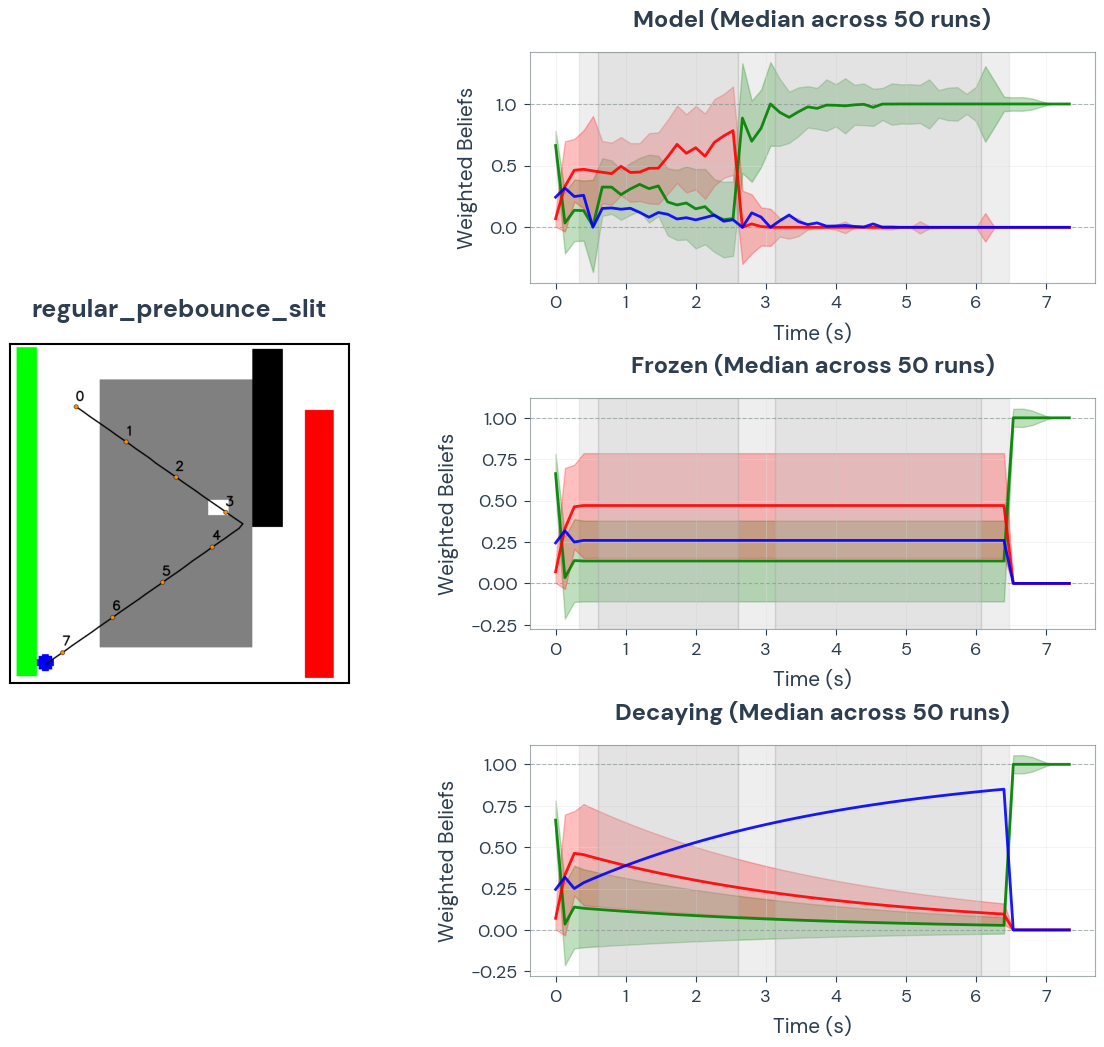

In [24]:
jtap_beliefs = jtap_compute_beliefs(JTAP_DATA)
jtap_run_idx = None
show_all_lines = False
show_std_band = True
jtap_plot_rg_lines(jtap_beliefs, stimulus = jtap_stimulus, show = "model", include_baselines=True, remove_legend=True, show_std_band=show_std_band, jtap_run_idx = jtap_run_idx, include_start_frame=True, show_all_beliefs=show_all_lines, plot_stat = "median", include_stimulus=True)

/tmp/ipykernel_376681/2480897761.py:75: UserWarning: include_human=True but no human data available in stimulus. Plotting without human data.
  warnings.warn("include_human=True but no human data available in stimulus. Plotting without human data.")
/tmp/ipykernel_376681/2480897761.py:661: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


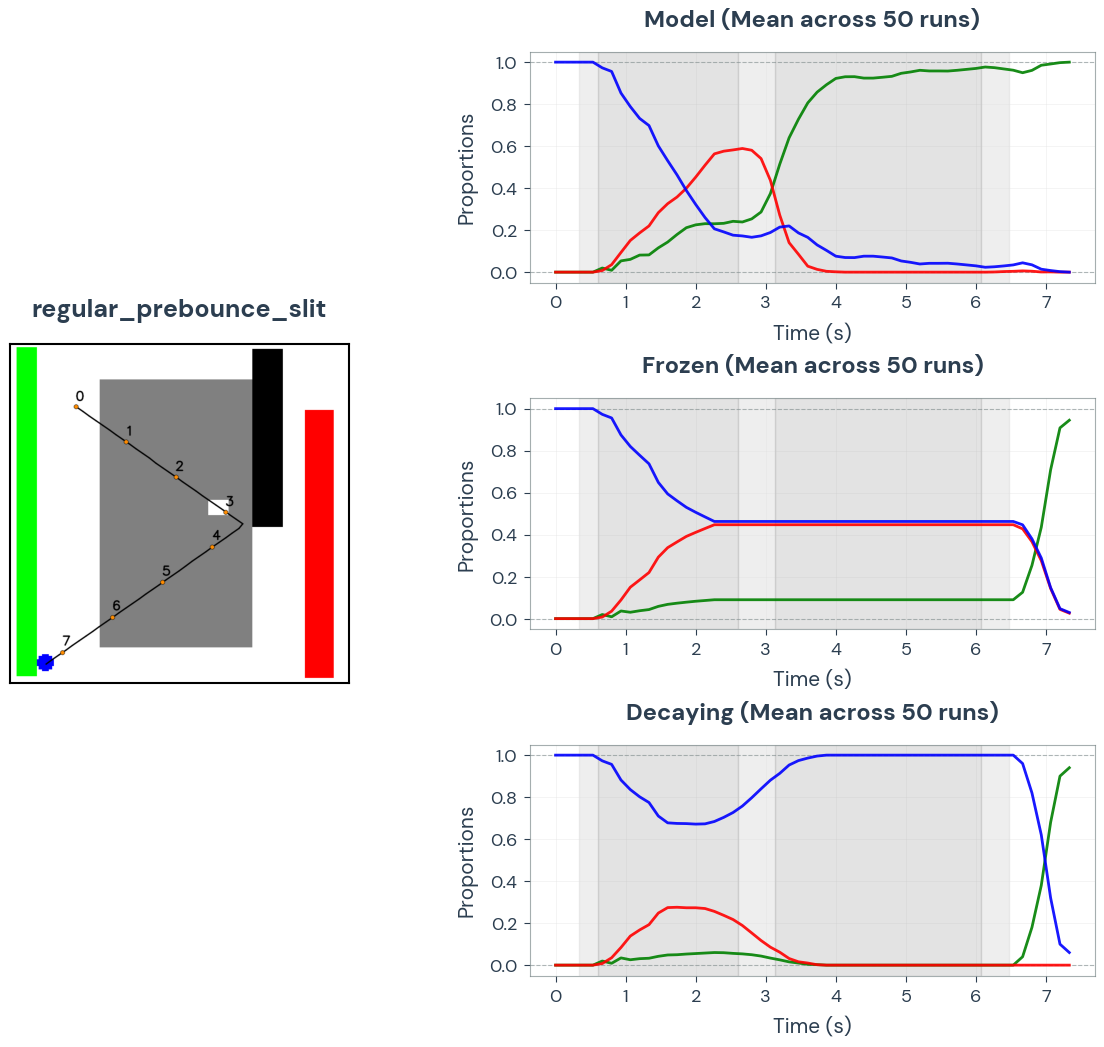

: 

In [ ]:
DECISION_MODEL_VERSION = "v4"

jtap_decision_model_hyperparams = JTAP_Decision_Model_Hyperparams(
    key_seed=123,
    pseudo_participant_multiplier=50,
    press_thresh_hyperparams=(0.5253067868385957, 0.030245679028864637, 0.0, 1.0),
    tau_press_hyperparams=(1.0, 0.01, np.arange(30)),
    hysteresis_delay_hyperparams=None,
    regular_delay_hyperparams=(4.0, 1.2362500260780824, np.arange(30)),
    starting_delay_hyperparams=(11.0, 3.794423573053696, np.arange(30))
)

jtap_decisions, jtap_decision_model_params = jtap_compute_decisions(
    jtap_beliefs,
    jtap_decision_model_hyperparams,
    decision_model_version=DECISION_MODEL_VERSION
)
# jtap_metrics = jtap_compute_decision_metrics(
#     jtap_decisions,
#     jtap_stimulus,
#     partial_occlusion_in_targeted_analysis=True,
#     ignore_uncertain_line=True
# )

jtap_metrics = None

jtap_plot_rg_lines(
    jtap_decisions,
    stimulus=jtap_stimulus,
    show="model",
    include_baselines=True,
    include_human=True,
    jtap_metrics=jtap_metrics,
    jtap_run_idx=jtap_run_idx,
    remove_legend=True,
    include_start_frame=True,
    plot_stat="mean",
    include_stimulus=True
)

In [ ]:
jtap_run_idx_viz = 9

rerun_jtap_single_run(JTAP_DATA, rgb_video_highres = None, stimulus_name = "jtap_single_runv3", tracking_dot_size_range = (0.5,2), prediction_line_size_range = (0.05,0.4), jtap_run_idx = jtap_run_idx_viz, grid_dot_radius = 0.3, render_grid = True, show_velocity = True)

In [ ]:
draw_stimulus_image(jtap_stimulus, frame=1)